In [1]:
from wgan import WGAN
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # gp loss won't work with eager
from functools import partial
from NuRadioReco.utilities import fft
from NuRadioReco.utilities import units
from NuRadioReco.framework import base_trace
import sys
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("analyze.py"))))
sys.path.insert(1, '/lustre/fs22/group/radio/dhjelm/')
import data_preprocessing
import analyze

In [2]:
wgan = WGAN()


Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           [(None, 128, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 32)           128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           3104      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 32)           0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 256, 16)           1552      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 16)           0 

# Data

In [3]:
dataset = np.load('/lustre/fs22/group/radio/dhjelm/data.npy')
np.random.shuffle(dataset)

In [4]:
# RMS
rms = data_preprocessing.rms_preprocessing(dataset)

# L1
l1 = data_preprocessing.l1_preprocessing(rms)

# Remove DC-offset
fft_traces = fft.time2freq(l1, 3.2*units.GHz)
no_offset = fft_traces[:,1:len(fft_traces[0])]
data_no_offset = fft.freq2time(no_offset, 3.2*units.GHz)

# Shorten the trace
short = data_no_offset[:,0:512]

# Normalization
normalize = data_preprocessing.normalize(short)

# Set data to the normailzed data
data = normalize


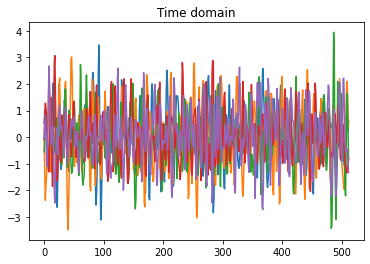

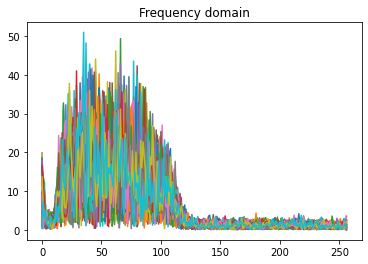

In [5]:
for i in range(5):
    plt.plot(data[i])
plt.title("Time domain")
plt.show()

for i in range(50):
    plt.plot(abs(fft.time2freq(data[i], 3.2*units.GHz)))
plt.title("Frequency domain")
plt.show()


In [6]:
# Create arrays for generator and critic loss
generator_loss = []
critic_loss = []

In [7]:
# Keras throws an error when calculating a loss without having a label -> needed for using the gradient penalty loss
positive_y = np.ones(wgan.batch_size)
negative_y = -positive_y
dummy = np.zeros(wgan.batch_size) 


In [8]:
# Training parameters
EPOCHS = 20
nsamples = len(data)
critic_iterations = 5
iterations_per_epoch = nsamples*2//(wgan.batch_size*critic_iterations)
iters = 0

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Iteration 1501
Critic loss: [-0.13805434, -0.59172565, 0.3838231, 0.06984821]
Generator loss: 0.552372


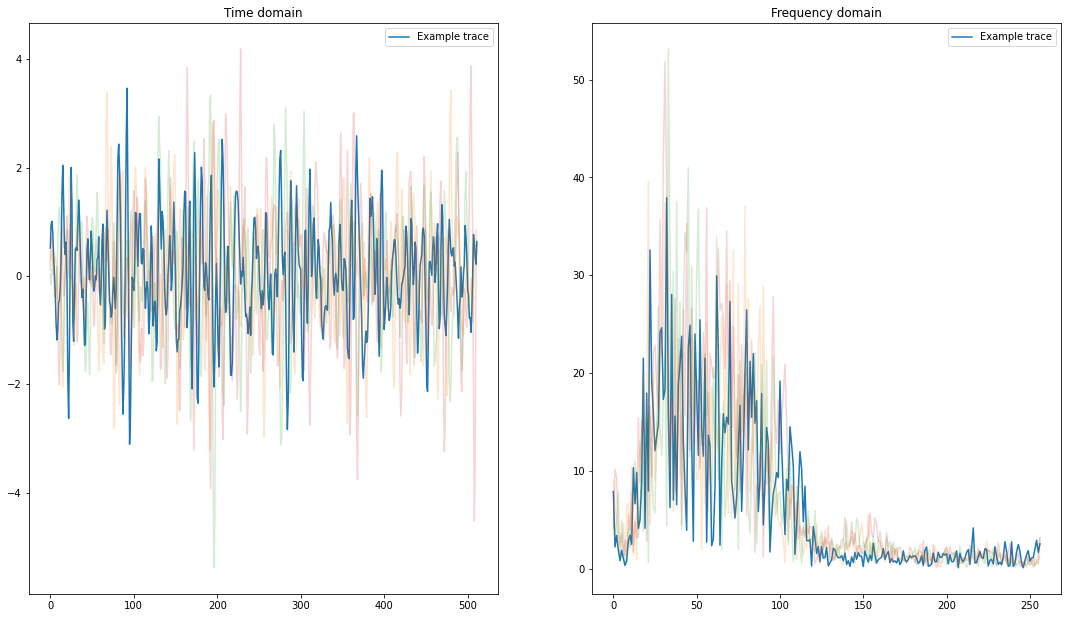

Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Iteration 1801
Critic loss: [-0.155684, -0.5726707, 0.36254066, 0.05444605]
Generator loss: 0.56550205


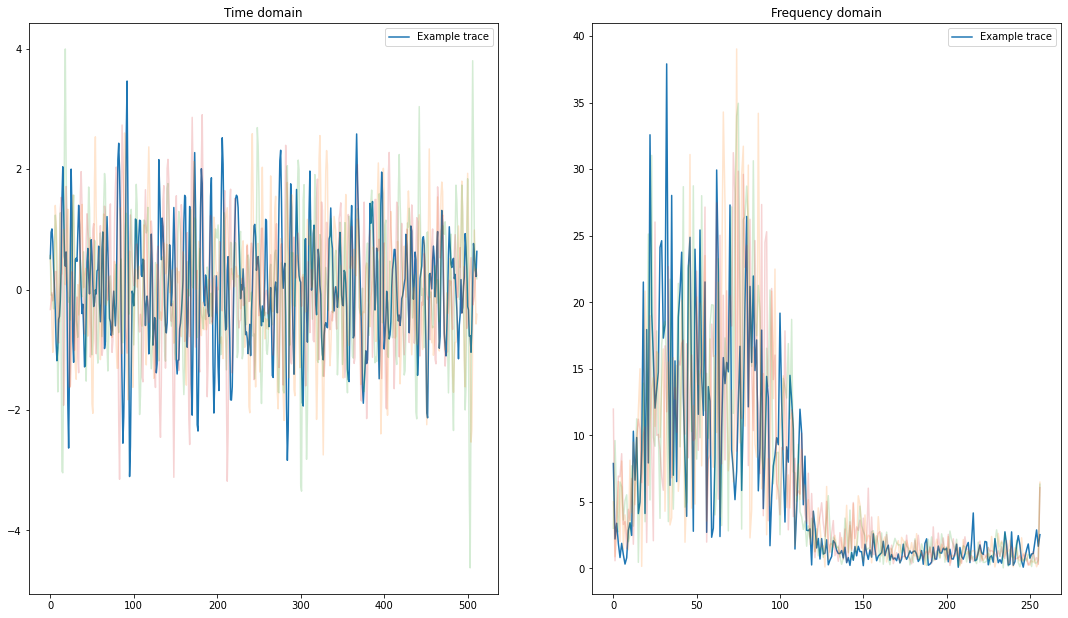

Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Iteration 2101
Critic loss: [-0.19756457, -0.5753598, 0.3322137, 0.04558155]
Generator loss: 0.65061677


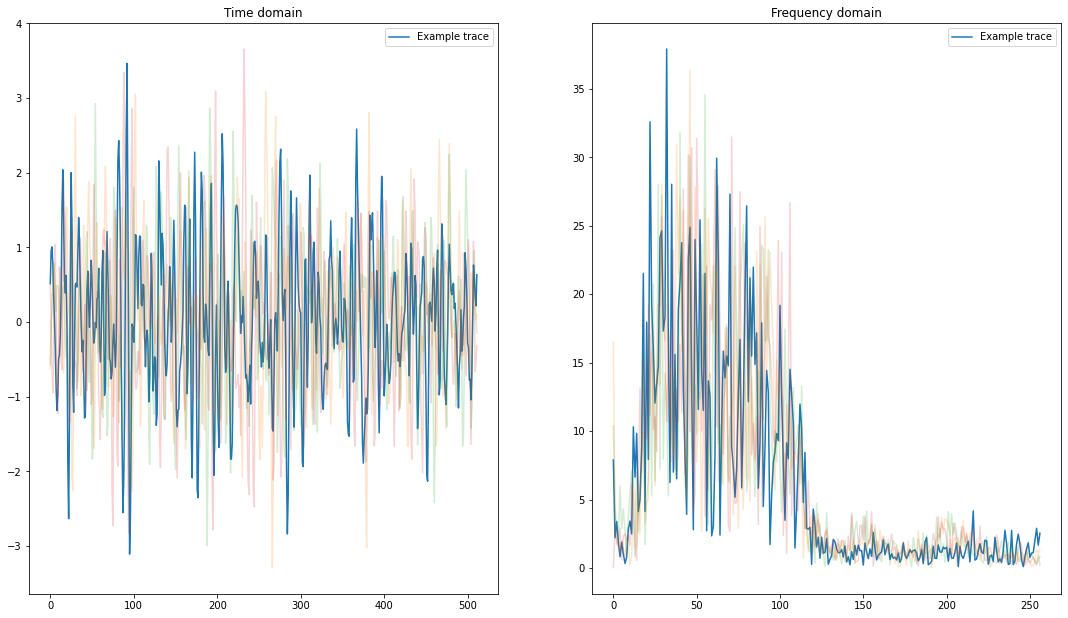

Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Iteration 2401
Critic loss: [-0.12387085, -0.5611162, 0.37207383, 0.065171555]
Generator loss: 0.5867737


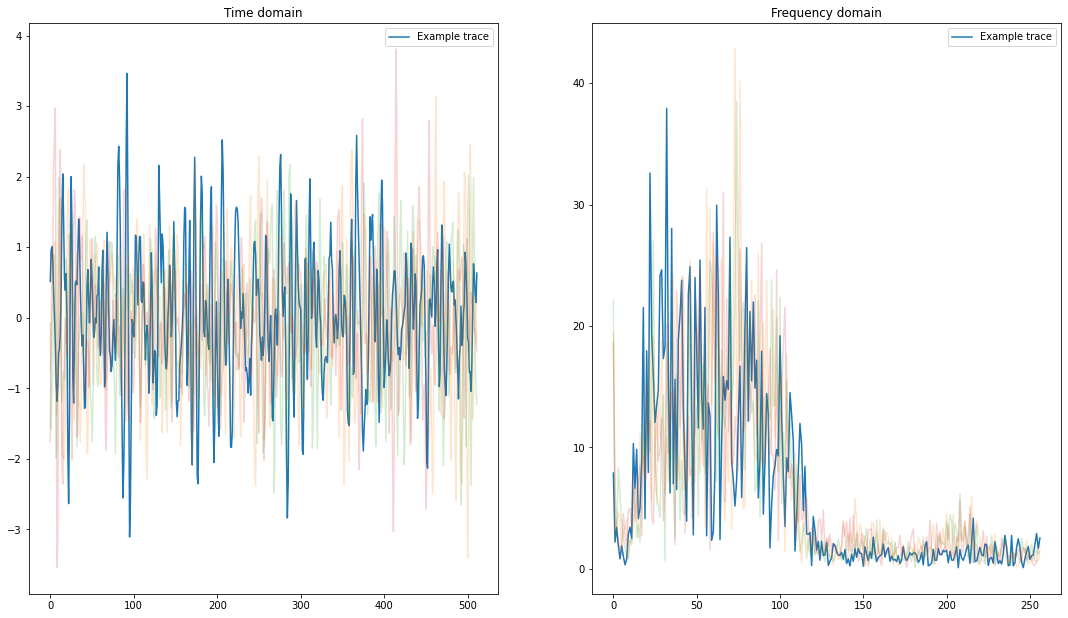

Epoch:  17
Epoch:  18
Epoch:  19


In [17]:

for epoch in range(EPOCHS):
    
    print("Epoch: ", epoch)

    for iteration in range(iterations_per_epoch):
       
        for j in range(critic_iterations):
            
            # Pick data in batches 
            bunch=data[wgan.batch_size*(j+iteration):wgan.batch_size*(j++iteration+1)]
            bunch = np.expand_dims(bunch, axis=-1)  

            # Generate noise
            noise_batch = np.random.randn(wgan.batch_size, wgan.latent_size)
            noise_batch = np.expand_dims(noise_batch, axis=-1) 

            
            # Train critic
            critic_loss.append(wgan.critic_training.train_on_batch([noise_batch, bunch], [negative_y, positive_y, dummy]))
        

        # Generate noise batch for generator
        noise_batch = np.random.randn(wgan.batch_size, wgan.latent_size)
        noise_batch = np.expand_dims(noise_batch, axis=-1) 
        
        # Train the generator
        generator_loss.append(wgan.generator_training.train_on_batch([noise_batch], [positive_y]))  
        iters+=1
        
        # Printing losses and plotting example traces
        if iters % 300 == 1:
            print("Iteration", iters)
            print("Critic loss:", critic_loss[-1])
            print("Generator loss:", generator_loss[-1])
            
            # Generate signals
            noise = np.random.randn(wgan.batch_size, wgan.latent_size)
            noise = np.expand_dims(noise, axis=-1) 
            generated_signals = wgan.generator.predict_on_batch(noise)
            generated_signals = generated_signals[:,:,0]
            
            
            # Plot data
            
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(18.5, 10.5, forward=True)
            ax1.title.set_text('Time domain')
            ax2.title.set_text('Frequency domain')
            
            

            ax1.plot(data[0], label = "Example trace")
#             plt.plot(np.random.randn(trace_length), label = 'Random noise')
            for i in range(3):
                ax1.plot(generated_signals[i], alpha=0.2)
            
            
            # Plot frequency
            ax2.plot(abs(fft.time2freq(data[0], 3.2*units.GHz)), label = "Example trace")
            for i in range(3):
                ax2.plot(abs(fft.time2freq(generated_signals[i], 3.2*units.GHz)),alpha=0.2)
                
            ax1.legend()
            ax2.legend()
            plt.show()


# Analyze results

In [10]:
noise = np.random.randn(len(data), wgan.latent_size)
noise = np.expand_dims(noise, axis=-1) 
generated_signals = wgan.generator.predict_on_batch(noise)
generated_signals = generated_signals[:,:,0]

In [11]:
analyze.metrics(data, generated_signals)

Mean generated: -0.031305719166994095
Mean data: 4.783611270407128e-18

Std generated: 1.0394335985183716
Std data: 1.0000000000000002



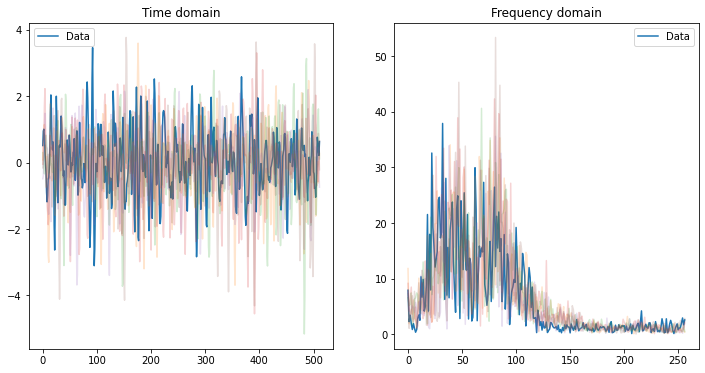

In [12]:
analyze.plot_traces(data, generated_signals, 5)

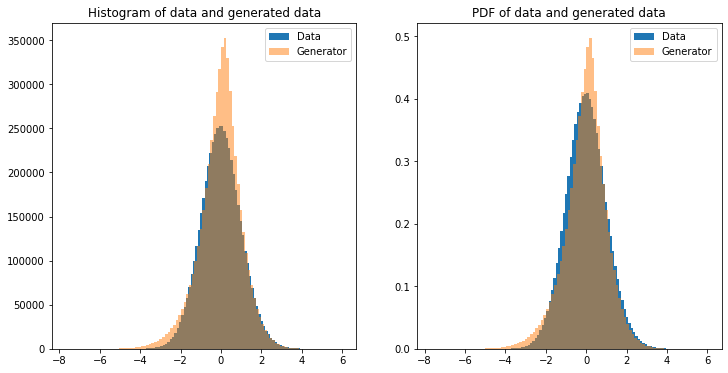

In [14]:
analyze.plot_histograms_time(data, generated_signals)


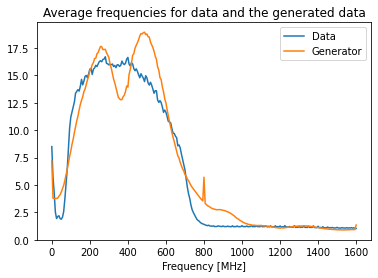

In [15]:
analyze.avg_frequencies(data, generated_signals)

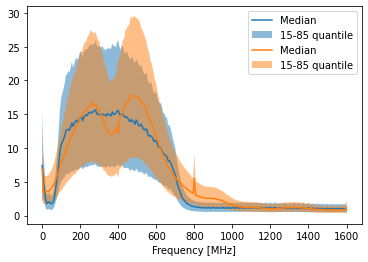

In [16]:
analyze.quantile_frequencies(data, generated_signals)